In [1]:
import datetime
import weatherMethods
import timeMethods
from imp import reload
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tools import press, proxilvl, g
import pickle
from sklearn.neighbors import KDTree, BallTree, NearestNeighbors
from scipy.spatial import cKDTree
%matplotlib inline

In [2]:
reload(weatherMethods)
reload(timeMethods)

<module 'timeMethods' from '/home/liuyulin101/Desktop/Wind_Mining/timeMethods.py'>

## Debug weatherMethods

In [3]:
# UTC Flight Departure Time
departureTime = datetime.datetime(2013, 2, 4, 18, 50)
arrivalTime = datetime.datetime(2013, 2, 4, 20, 30)
print(departureTime)

# This function downloads all the data needed for the flight
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
# meteoDT, winds, lvls, valid_timeTags

#Current position
lon = -90
lat = 43
# Current altitude (ft)
alt = 30000

# UTC time at currentpostion
t = datetime.datetime(2013, 2, 4, 20, 15)

# Last position
lonl = -89.9
latl= 43.1
# This function gives wind value at current position (m/s)
wind  = WindClass.getWind(lon, lat, alt, t, lonl, latl)
print(wind)

2013-02-04 18:50:00
2.27861851883


In [5]:
WindClass.final_timeTags

['001', '002']

## Wind Visualization

In [6]:
# create figure and axes instances
def PlotWind(Winds, AirPressure, Resolution = 120, Scale = 2500,Time = '02/04/2013 19:00 Zulu'):
    fig = plt.figure(figsize=(16,12))
    plt.title('Wind Speed (m/s), ' + Time + '. Elevation: ' + str(AirPressure) + ' mbar')
    # create polar stereographic Basemap instance.
    latlb = 21
    latub = 50
    lonlb = -127
    lonub = -67
    m = Basemap(projection='merc',llcrnrlat = latlb, urcrnrlat = latub, llcrnrlon = lonlb,urcrnrlon = lonub)
#     m.bluemarble()
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines(linewidth=1)
    m.drawstates(linewidth=0.25)
    m.drawcountries(linewidth=1)
    # m.drawmeridians(np.arange(-120,-80,10))
    # m.drawparallels(np.arange(10,50,5))
    
    u_wind = Winds[0][0][WindClass.lvls[AirPressure]].data(lat1 = latlb, lat2 = latub,lon1 = lonlb, lon2 = lonub)
    v_wind = Winds[0][1][WindClass.lvls[AirPressure]].data(lat1 = latlb, lat2 = latub,lon1 = lonlb, lon2 = lonub)
    # m/s
    u = u_wind[0]
    v = v_wind[0]
    x = u_wind[2]
    y = u_wind[1]
    z = np.sqrt(u**2 + v**2)
    
    xi = np.linspace(min(x), max(x), 30)
    yi = np.linspace(min(y), max(y), 30)
    ui = griddata((x, y), u, (xi[None,:], yi[:,None]), method='linear')
    vi = griddata((x, y), v, (xi[None,:], yi[:,None]), method='linear')
    xi,yi = m(xi,yi)
    Q = plt.quiver(xi,yi,ui,vi, scale = Scale, zorder = 10)
    

    xii = np.linspace(min(x), max(x), Resolution)
    yii = np.linspace(min(y), max(y), Resolution)
    zi = griddata((x, y), z, (xii[None,:], yii[:,None]), method='linear')

    xii, yii = m(xii,yii)
    CS = plt.contourf(xii,yii,zi,30,cmap=plt.cm.jet, zorder = 0)

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(CS, cax=cax)
    cb.set_label('m/s')
    qk = plt.quiverkey(Q, 0, 0, 100, '100 m/s', labelpos='W', color = 'r', labelcolor='k')
    
    return xii,yii,zi

In [8]:
# UTC Flight Departure Time
departureTime = datetime.datetime(2013, 2, 4, 18, 50)
arrivalTime = datetime.datetime(2013, 2, 4, 20, 30)
print(departureTime)

# This function downloads all the data needed for the flight
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
Winds = WindClass.winds

2013-02-04 18:50:00


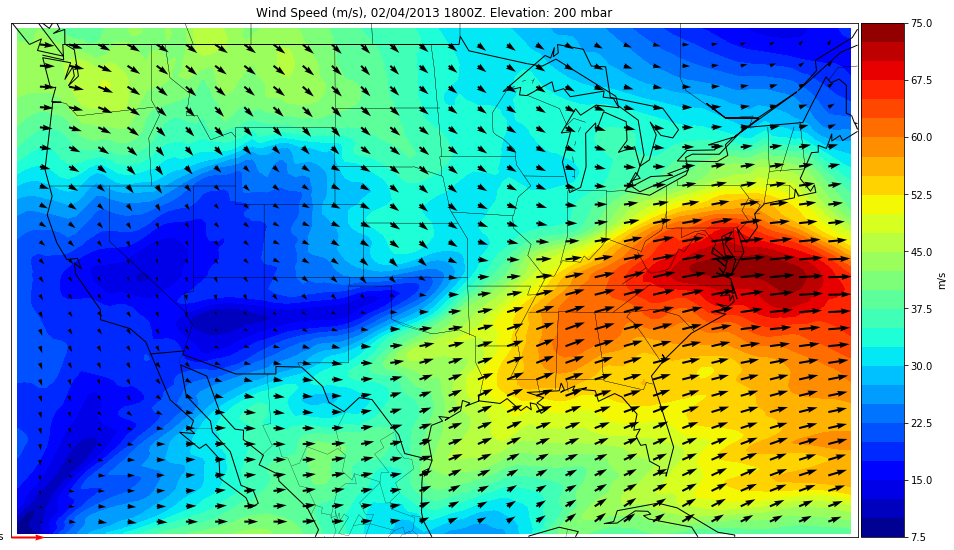

In [13]:
m = PlotWind(Winds, 200, Time = '02/04/2013 1800Z')
# 38000 ft

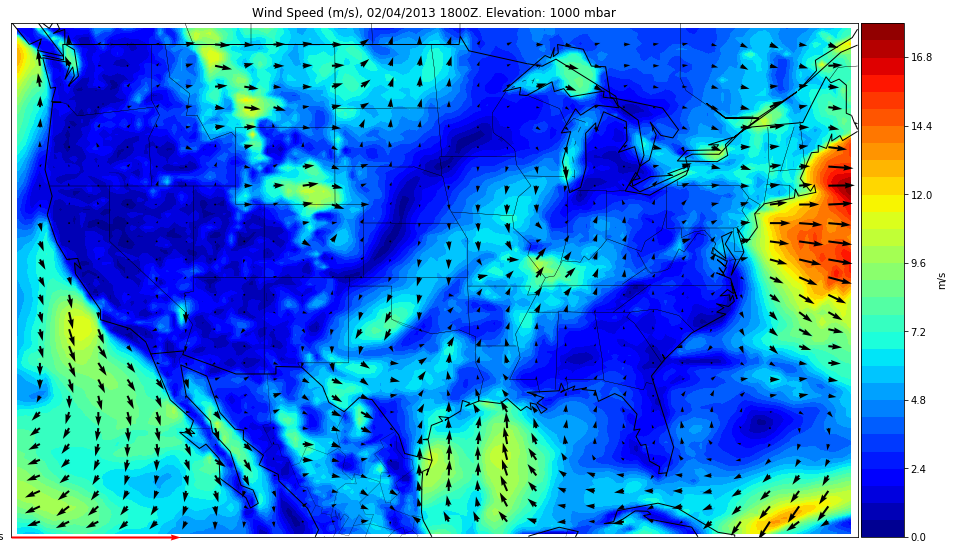

In [14]:
m1 = PlotWind(Winds, 1000, Scale = 500,Time = '02/04/2013 1800Z')

In [15]:
departureTime = datetime.datetime(2013, 1, 1, 18, 50)
arrivalTime = datetime.datetime(2013, 1, 1, 20, 30)
# This function downloads all the data needed for the flight
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
Winds = WindClass.winds

In [16]:
WindClass.lvls.keys()

dict_keys([450, 900, 325, 775, 200, 650, 525, 975, 400, 850, 275, 725, 150, 600, 475, 925, 350, 800, 225, 675, 550, 1000, 425, 875, 300, 750, 175, 625, 500, 950, 375, 825, 250, 700, 575])

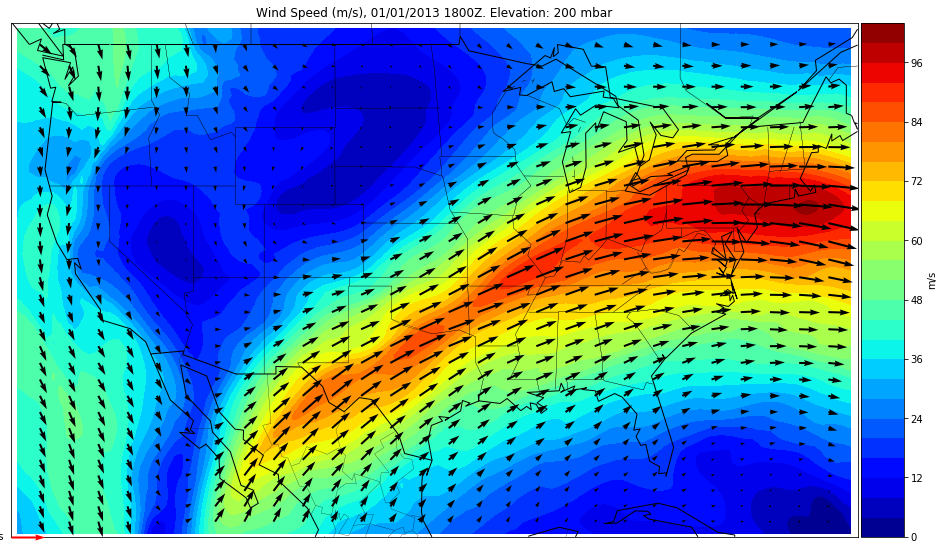

In [19]:
m2 = PlotWind(Winds, 200, Time = '01/01/2013 1800Z')

## Test on Trajectory Matching

In [2]:
VTrackPath = os.getcwd() + '/TFMS_NEW/New_IAHBOS2013.csv'
VTrack = pd.read_csv(VTrackPath, parse_dates=[6])

In [100]:
VTrack.head()

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist,Pressure
0,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:08:00,29.983333,-95.300000,8,159,471666-UAL386,0.0,0.000000,0.000000,0.000000,975
1,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:09:00,30.016667,-95.266667,26,253,471666-UAL386,60.0,2.647485,0.044125,2.647485,925
2,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:11:00,30.166667,-95.233333,86,300,471666-UAL386,120.0,9.170856,0.076424,11.818341,725
3,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:12:00,30.250000,-95.216667,109,300,471666-UAL386,60.0,5.077461,0.084624,16.895802,675
4,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:13:00,30.366667,-95.183333,130,334,471666-UAL386,60.0,7.214531,0.120242,24.110333,625


In [128]:
Sample = VTrack[VTrack.FID == 20130101632288]

In [129]:
Sample.head(3)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist,Pressure
0,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:08:00,29.983333,-95.300000,8,159,471666-UAL386,0.0,0.000000,0.000000,0.000000,975
1,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:09:00,30.016667,-95.266667,26,253,471666-UAL386,60.0,2.647485,0.044125,2.647485,925
2,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:11:00,30.166667,-95.233333,86,300,471666-UAL386,120.0,9.170856,0.076424,11.818341,725


In [135]:
a = VTrack.Alt.values
b = np.roll(a,1)
c = abs(b-a)
np.where(c > 200)

(array([ 93277,  93278, 155078, 155079, 160260, 160262, 160640, 160641,
        183211, 190806, 190807, 247957, 247958]),)

In [158]:
VTrack.ix[183211,'FID']

20130811346449

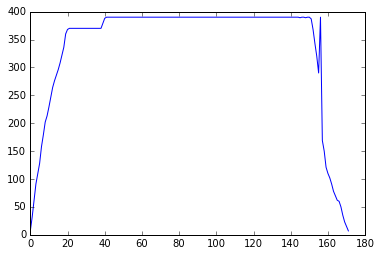

In [156]:
plt.plot(VTrack[VTrack.FID == VTrack.ix[183211,'FID']].Alt.values)

In [148]:
VTrack[VTrack.FID == VTrack.ix[93277,'FID']].tail(5)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist
93273,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:14:00,42.233333,-70.883333,36,238,148108-N598WC,60.0,4.070687,0.067845,1476.083206
93274,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:15:00,42.283333,-70.916667,24,180,148108-N598WC,60.0,3.347505,0.055792,1479.430711
93275,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:16:00,42.316667,-70.950000,10,123,148108-N598WC,60.0,2.489243,0.041487,1481.919954
93276,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:17:00,42.350000,-70.983333,5,162,148108-N598WC,60.0,2.488777,0.041480,1484.408731
93277,20130513743239,148108,N598WC,13-MAY-13 00:00:00,IAH,BOS,2013-05-13 23:19:00,42.433333,-71.066667,230,162,148108-N598WC,120.0,6.219902,0.051833,1490.628633


In [9]:
st = time.time()
depTime = Sample.Elap_Time.iloc[0]
arrTime = Sample.Elap_Time.iloc[-1]

Position = Sample[['Lat','Lon','Alt']].values
Position[:,2] = Position[:,2] * 100
TimeStamp = Sample.Elap_Time

WindClass = weatherMethods.GetWindSpeed(depTime, arrTime)
lastPos = Position[0]

WindSpeed = [0]
for idx in range(Position.shape[0] - 1):

    curPos = Position[idx + 1]
    curTime = TimeStamp.iloc[idx+1]
    wind  = WindClass.getWind(curPos[1], curPos[0], curPos[2], curTime,lastPos[1], lastPos[0])
    WindSpeed.append(wind)
    lastPos = curPos
    
print(time.time() - st)

45.548314571380615


In [ ]:
Sample['WindSpeed'] = 0
Sample.loc[1:,'WindSpeed'] = np.array(WindSpeed)
Sample['AirSpeed'] = Sample.GroundSpeed * 1.852 - Sample.WindSpeed
Sample['WindDist'] = Sample.AirSpeed * Sample.DT /3600 * 0.539957

In [145]:
print(sum(Sample.WindDist))
print(sum(Sample.Dist))

1260.33594474
1460.54414964


In [87]:
pickle.dump(Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967), 
            open('test.p','wb'))

In [91]:
getsizeof(Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967))

72

## Try nearest neighbor

### Initialize Grid System. Construting level-specific KDTree

In [2]:
departureTime = datetime.datetime(2013, 1, 1, 1, 30)
arrivalTime = datetime.datetime(2013, 1, 1, 6, 30)
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
Winds = WindClass.winds

In [ ]:
Tree_Dict = {}
i = 0
for levels in WindClass.lvls.keys():
    i += 1
    Grid_lat, Grid_lon = Winds[0][0][WindClass.lvls[levels]].data(22, 52, -130, -60)[1:3]
#     print(Grid.shape) 145999 * 2
    Grid = np.dstack((Grid_lat, Grid_lon))[0]
    Tree_Dict[levels] = cKDTree(Grid)

In [48]:
pickle.dump(Tree_Dict, open('Grid_KDTree.p','wb'))

# Mapping Trajectories

In [2]:
VTrackPath = os.getcwd() + '/TFMS_NEW/New_IAHBOS2013.csv'
VTrack = pd.read_csv(VTrackPath, parse_dates=[6])
LabelData = pd.read_csv(os.getcwd() + '/TFMS_NEW/Label_IAH_BOS_2013.csv')
Sample = VTrack[VTrack.FID == 20130101632288].reset_index(drop = 1)

In [3]:
CenterTraj = VTrack[VTrack.FID.isin(LabelData[LabelData.MedianID != -2].FID.values)].reset_index(drop = 1)

In [4]:
st = time.time()
depTime = Sample.Elap_Time.iloc[0]
arrTime = Sample.Elap_Time.iloc[-1]

Position = Sample[['Lat','Lon','Alt']].values
Position[:,2] = Position[:,2] * 100

WindClass = weatherMethods.GetWindSpeed(depTime, arrTime)
print(time.time() - st)

uniquelvl = []

for i in range(Position.shape[0]):
    alt = Position[i,2]
    pro_lvl = proxilvl(alt,WindClass.lvls)
    Position[i,2] = pro_lvl
    if pro_lvl not in uniquelvl:
        uniquelvl.append(pro_lvl)
    else:
        pass
print(time.time() - st)

Winds = WindClass.winds
for i in range(len(uniquelvl)):
    if uniquelvl[i] >= 300:
#         31.31666667,   -94.3
#         29.95,   -95.35
#         40.76666667,   -73.6
#         42.33333333,   -70.96666667
        u_lat = 31.31666667
        b_lat = 29.95
        u_lon = -94.3
        b_lon = -95.35
        u_wind = Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = b_lat, lat2 = u_lat,lon1 = b_lon, lon2 = u_lon)
        v_wind = Winds[0][1][WindClass.lvls[uniquelvl[i]]].data(lat1 = b_lat, lat2 = u_lat,lon1 = b_lon, lon2 = u_lon)
    else:
        u_lat = 40.66666667
        b_lat = 31.45
        u_lon = -73.75
        b_lon = -94.2
        u_wind = Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = b_lat, lat2 = u_lat,lon1 = b_lon, lon2 = u_lon)
        v_wind = Winds[0][1][WindClass.lvls[uniquelvl[i]]].data(lat1 = b_lat, lat2 = u_lat,lon1 = b_lon, lon2 = u_lon)
    
    u_windspeed = u_wind[0]
    lat = u_wind[1]
    lon = u_wind[2]
    pres_lvl = np.ones(lat.shape) * uniquelvl[i]
    v_windspeed = v_wind[0]

    if i == 0:
        wind_array = np.dstack((lat, lon, pres_lvl, u_windspeed, v_windspeed))[0]

    else:
        temp_wind = np.dstack((lat, lon, pres_lvl, u_windspeed, v_windspeed))[0]
        wind_array = np.append(wind_array, temp_wind, axis = 0)

print(time.time() - st)
# tree = cKDTree(wind_array[:,:3], leafsize = 100)
# print(time.time() - st)
# _, near_idx = tree.query(Position[:,:3], k = 1)
# wind_vector = wind_array[near_idx,3:]
# print(time.time() - st)

0.6891114711761475
0.6932041645050049
5.6611387729644775
